<a href="https://colab.research.google.com/github/DelaramRajaei/multi_label_text_classification/blob/main/multi_label_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label text classification

** Dataset size is not enough to train the model. If we add more layers, it will overfit and on the other hand, if we use more dropout or regularization(methods to overcome overfitting) the model accuracy will we low and arround 50%.
However I manged to tackle the issue of overfitting and increase the accuracy up to 85.9%.

In [1]:
!nvidia-smi

Sun Feb 26 15:18:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Information



**Author:** [Farrokh Karimi](https://farrokhkarimi.github.io/)  
**Edited By:** [Delaram Rajaei](https://delaramrajaei.github.io/)  
**Description:** In this notebook, we want to classify the Ronash dataset into 20 category.

Edits can be found by "# Edited" tags.

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import torch

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from collections import Counter

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

## Dataset

### Download Dataset

In [3]:
# downloading Data from the Google Drive link
!gdown 1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy

Downloading...
From: https://drive.google.com/uc?id=1Yq3XTnACkvaIiNlhX09Zth55nOau7jQy
To: /content/Ronash_DS_Assignment.csv
100% 1.05M/1.05M [00:00<00:00, 103MB/s]


In [4]:
ls

Ronash_DS_Assignment.csv  sample_data/


In [5]:
# reading the csv file as a dataframe
df = pd.read_csv('Ronash_DS_Assignment.csv')
df

,product_id,title,vendor,tags,category
0,3937721221199,Fidele Super Premium Adult Large Breed Dog Food,Fidele,"['Adult', 'Bangalore', 'Chennai', 'Chicken', '...",Animals & Pet Supplies
1,7353058033889,Foldable Pet Toys Linen Storage,Cap Point,[],Animals & Pet Supplies
2,6594773549129,Bok Dok Diaper,Pets Home,"['Brand_Pet Arabia', 'Category_Pets Home', 'Ca...",Animals & Pet Supplies
3,4802008318014,Tastybone Toy Chicken,TastyBone,[],Animals & Pet Supplies
4,1779705151539,Leather Leash Tab - Short Dog Leash,Mighty Paw,"['Leash', 'Leash Tab', 'Training']",Animals & Pet Supplies
...,...,...,...,...,...
5265,4637089464407,Candylab MOO Milk Van,Candylab,"['3 Years +', 'candylab', 'Discount Products',...",Vehicles & Parts
5266,4996632444987,"Truck - Modern Era Vehicles -- Red, White - S...",Woodland Scenics,"['HO Scale', 'ho-scale-items', 'vehicles', 'wo...",Vehicles & Parts
5267,5528541003927,Car Sticker Flags Decal American Flag Sticker for,Cyan Selene,['Other'],Vehicles & Parts
5268,1395163889730,Lazer Helmets Bayamo Pit Bull - Full Face,OPEN BOX BARGAINS,"['65061090', 'Antiscratch Pinlock Ready Visor'...",Vehicles & Parts


### Dataset Information

In [6]:
# counting the number of each label
df['category'].value_counts()

Apparel & Accessories        1000
Animals & Pet Supplies        500
Food, Beverages & Tobacco     400
Sporting Goods                400
Luggage & Bags                400
Home & Garden                 400
Health & Beauty               400
Media                         300
Toys & Games                  300
Furniture                     200
Baby & Toddler                200
Arts & Entertainment          200
Electronics                   100
Business & Industrial         100
Office Supplies               100
Vehicles & Parts              100
Hardware                       50
Cameras & Optics               50
Software                       50
Religious & Ceremonial         20
Name: category, dtype: int64

In [7]:
# counting how many indices are duplicated in each column
print(f"There are {sum(df['title'].duplicated())} duplicate title.")
print(f"There are {sum(df['vendor'].duplicated())} duplicate vondor.")
print(f"There are {sum(df['tags'].duplicated())} duplicate tags.")

There are 0 duplicate title.
There are 1256 duplicate vondor.
There are 716 duplicate tags.


In [8]:
# counting the number of Nan samples
df.isnull().values.sum()

3

There are just 3 Nan samples in the dataset and we delete them.

### Cleaning Dataset

In [9]:
# Edited
# Remove 3 rows with null values on the current dataframe.
df.dropna(axis=0, inplace=True)
# check if null values are removed properly.
df.isnull().values.sum()

0

In [10]:
# the function for extracting and standardizing the sentences
def text_extraction(dfi):
  # in this function, we concatenate text feature parts of the data as a sentence
  sentence = ' '.join([dfi['title'], str(dfi['vendor']), dfi['tags']])
  # Remove punctuations
  sentence = re.sub('[^a-zA-Z0-9$.]', ' ', sentence)
  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)
  # Changint to lowercase
  sentence = sentence.lower()
  return sentence

# printing 10 sample sentences
for i in range(10):
  print(text_extraction(df.iloc[i]))

fidele super premium adult large breed dog food fidele adult bangalore chennai chicken doberman dog dry foods fidele german shepherd golden retriever great dane highpriority imported labrador less than 1000 less than 2000 less than 500 mastiff orange pet nutrition 
foldable pet toys linen storage cap point 
bok dok diaper pets home brand pet arabia category pets home category small pets supplies type pet home type pet supplies 
tastybone toy chicken tastybone 
leather leash tab short dog leash mighty paw leash leash tab training 
pridebites texas guitar dog toy pride bites brand pridebites toy type plush 
burns sensitive pork potato burns 10 25 25 50 50 75 adult burns coat dog food food delivery jansale18 natural nonsale19 sensitive size 12kg size 2kg size 6kg skin 
bully sticks dog toy adog.co bully sticks dog chew toys dog toys 
kazoo tough giraffe dog toy kazoo brand kazoo june2021 kazoo material plush plush 
orgo dog biscuits fresh milk petku brand orgo category dogs dogs lifestage

In [11]:
# creating the dataset
dataset = pd.DataFrame(columns=['text', 'label'])
for i in range(len(df)):
  dataset = dataset.append({'text':text_extraction(df.iloc[i]), 'label':df.iloc[i]['category']}, ignore_index = True)

# creating integer labels for multiclass training
dataset['label_int'] = pd.Categorical(dataset['label']).codes
dataset

,text,label,label_int
0,fidele super premium adult large breed dog foo...,Animals & Pet Supplies,0
1,foldable pet toys linen storage cap point,Animals & Pet Supplies,0
2,bok dok diaper pets home brand pet arabia cate...,Animals & Pet Supplies,0
3,tastybone toy chicken tastybone,Animals & Pet Supplies,0
4,leather leash tab short dog leash mighty paw l...,Animals & Pet Supplies,0
...,...,...,...
5262,candylab moo milk van candylab 3 years candyla...,Vehicles & Parts,19
5263,truck modern era vehicles red white scale ho w...,Vehicles & Parts,19
5264,car sticker flags decal american flag sticker ...,Vehicles & Parts,19
5265,lazer helmets bayamo pit bull full face open b...,Vehicles & Parts,19


In [12]:
# extracting the names of the labels
labels_names = list(Counter(dataset['label']).keys())
labels_names

['Animals & Pet Supplies',
 'Apparel & Accessories',
 'Arts & Entertainment',
 'Baby & Toddler',
 'Business & Industrial',
 'Cameras & Optics',
 'Electronics',
 'Food, Beverages & Tobacco',
 'Furniture',
 'Hardware',
 'Health & Beauty',
 'Home & Garden',
 'Luggage & Bags',
 'Media',
 'Office Supplies',
 'Religious & Ceremonial',
 'Software',
 'Sporting Goods',
 'Toys & Games',
 'Vehicles & Parts']

In [13]:
# printing each integer label and its corresponding name label
for i, label in enumerate(labels_names):
  print("Label", i, "corresponds to", label)

Label 0 corresponds to Animals & Pet Supplies
Label 1 corresponds to Apparel & Accessories
Label 2 corresponds to Arts & Entertainment
Label 3 corresponds to Baby & Toddler
Label 4 corresponds to Business & Industrial
Label 5 corresponds to Cameras & Optics
Label 6 corresponds to Electronics
Label 7 corresponds to Food, Beverages & Tobacco
Label 8 corresponds to Furniture
Label 9 corresponds to Hardware
Label 10 corresponds to Health & Beauty
Label 11 corresponds to Home & Garden
Label 12 corresponds to Luggage & Bags
Label 13 corresponds to Media
Label 14 corresponds to Office Supplies
Label 15 corresponds to Religious & Ceremonial
Label 16 corresponds to Software
Label 17 corresponds to Sporting Goods
Label 18 corresponds to Toys & Games
Label 19 corresponds to Vehicles & Parts


## DataFrames

In [14]:
# splitting dataset to train, validation, and test dataframes
train_df, test_df= train_test_split(dataset, test_size=0.2, random_state=42)
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of samples in training set: {len(train_df)}")
print(f"Number of samples in validation set: {len(val_df)}")
print(f"Number of samples in test set: {len(test_df)}")

# extracting texts and labels from dataframes
train_texts = train_df['text']
train_labels = train_df['label_int']
val_texts = val_df['text']
val_labels = val_df['label_int']
test_texts = test_df['text']
test_labels = test_df['label_int']

Number of samples in training set: 4213
Number of samples in validation set: 527
Number of samples in test set: 527


In [15]:
# creating data generators with batch size 32
batch_size = 50
raw_train_batch = tf.data.Dataset.from_tensor_slices((train_texts, train_labels)).batch(batch_size)
raw_val_batch = tf.data.Dataset.from_tensor_slices((val_texts, val_labels)).batch(batch_size)
raw_test_batch = tf.data.Dataset.from_tensor_slices((test_texts, test_labels)).batch(batch_size)

# printing texts and labels of a batch of raw train
for text, label in raw_train_batch.take(1):
  print('Texts: {}'.format(text))
  print('labels: {}'.format(label))

Texts: [b'seachem multitest ammonia seachem '
 b'smart electric cat teasing toy pet clever cat toys cats rr track catproducts rr track cattoys '
 b'ocean hunter wood sculpture novica united inc assembly required 492 assembly requiredstr no assembly required class home accessories classid 581 color 5829 colorstr brown department decor departmentid 542 margin 60 material style 33 stylestr modern subclass home accessories subclassid 793 '
 b'impala rollerskates leopard impala cheetah impala leopard red roller skate rollerskate skate skates vegan '
 b'diy personalised dreamcatcher activity kit sea animal doxbox store '
 b'treasure by estetica remy human hair wig closeout estetica liquid show percent off show percent off '
 b'etching cl grenadine drapery upholstery fabric by kaufmann kaufmann hidden pk ikat khaki multi color print red shop fabric throw pillows trim wallpaper ikat shop fabric throw pillows trim wallpaper kaufmann shop fabric throw pillows trim wallpaper prints '
 b'bleed pro

### Information

In [16]:
# counting how many words are there in the whole texts of the dataset
num_of_words = 0
for i in dataset['text']: num_of_words += len(i.split())

print('Number of words: {}'.format(num_of_words))

Number of words: 112524


There are about 112000 words in the texts.



In [17]:
# Edited
# Counting max sequence length and how many non-repetitive words are there in the whole texts of the dataset
# Remove words repeated more that threshold. --> Remove outlier words

# Variables
non_repetitive_list = [] # List of all non repetitive words
words = {}               # Store all the words
max_seq_lenght = 0       # Max sequence
threshold = 800

# Iterate rows
for row in dataset.itertuples(index=True):
  index = getattr(row,'Index')
  text = getattr(row,'text')
  new_text = text 

  for each_word in text.split():
    if each_word not in non_repetitive_list: non_repetitive_list.append(each_word)

    # Update the dictionary and remove the word passing the threshold 
    # from keras.preprocessing.text import Tokenizer, could also be used 
    if each_word in words.keys():
      if  words[each_word] >= threshold: 
        new_text = new_text.replace(each_word, '')
      value = words[each_word]
      words.update({each_word: value+1})
    else: words[each_word]=1
  
  dataset.at[index, 'text'] = new_text 
  lenght = len(new_text.split())
  if lenght > max_seq_lenght: max_seq_lenght = lenght

print('Max sequence length: {}'.format(max_seq_lenght))
print('Non-repetitive words: {}'.format(len(non_repetitive_list)))

Max sequence length: 309
Non-repetitive words: 18927


Maximum sequence length is 309 and There are about 19000 non-repetitive words in the whole dataset texts. So we set max word features to 10000 and sequence length to 310.

### Preprocessing

In [18]:
# setting the text vectorization layer with 10000 words and 310 sequence length
max_features = 20000
sequence_length = max_seq_lenght + 1

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# fitting the state of the preprocessing layer to the train set. This will cause the model to build an index of strings to integers.
vectorize_layer.adapt(train_texts)

# defining the vectorize text function
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

# retrieving a sample from a batch of texts and labels from the train set
text_batch, label_batch = next(iter(raw_train_batch))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", first_label)
print("Vectorized text", vectorize_text(first_review, first_label))

Review tf.Tensor(b'seachem multitest ammonia seachem ', shape=(), dtype=string)
Label tf.Tensor(0, shape=(), dtype=int8)
Vectorized text (<tf.Tensor: shape=(1, 310), dtype=int64, numpy=
array([[ 2075,  6580, 15510,  2075,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     

In [19]:
# getting corresponding word of each integer 
print("1401 ---> ",vectorize_layer.get_vocabulary()[1401])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1401 --->  moderate
 313 --->  soft
Vocabulary size: 16371


### Caching the tensor datasets

In [20]:
# creating train, val, and test vectorized dataset and prefetching them
train_ds = raw_train_batch.map(vectorize_text)
val_ds = raw_val_batch.map(vectorize_text)
test_ds = raw_test_batch.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Building the Simple Keras Model

### Initializing Model

In [45]:
# model configuration
embedding_dim = 32
num_of_labels = 20
vocab_size = len(vectorize_layer.get_vocabulary())

model = tf.keras.Sequential([
  layers.Embedding(vocab_size + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(num_of_labels)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          523904    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 20)                660       
                                                                 
Total params: 524,564
Trainable params: 524,564
Non-trainable params: 0
__________________________________________________

In [46]:
# model compilation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train

In [47]:
# training the model
epochs = 500

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=[callback])

Epoch 1/500
85/85 [==============================] - 18s 149ms/step - loss: 2.9258 - accuracy: 0.1645 - val_loss: 2.8274 - val_accuracy: 0.2030
Epoch 2/500
85/85 [==============================] - 0s 4ms/step - loss: 2.7661 - accuracy: 0.1878 - val_loss: 2.6693 - val_accuracy: 0.2030
Epoch 3/500
85/85 [==============================] - 0s 4ms/step - loss: 2.6916 - accuracy: 0.1878 - val_loss: 2.6324 - val_accuracy: 0.2030
Epoch 4/500
85/85 [==============================] - 0s 4ms/step - loss: 2.6781 - accuracy: 0.1878 - val_loss: 2.6231 - val_accuracy: 0.2030
Epoch 5/500
85/85 [==============================] - 1s 6ms/step - loss: 2.6698 - accuracy: 0.1878 - val_loss: 2.6173 - val_accuracy: 0.2030
Epoch 6/500
85/85 [==============================] - 1s 6ms/step - loss: 2.6662 - accuracy: 0.1878 - val_loss: 2.6123 - val_accuracy: 0.2030
Epoch 7/500
85/85 [==============================] - 1s 6ms/step - loss: 2.6588 - accuracy: 0.1878 - val_loss: 2.6074 - val_accuracy: 0.2030
Epoch 8/50

### Test

In [48]:
# printing loss and accuracy of the model on the test set
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

11/11 [==============================] - 0s 8ms/step - loss: 0.7334 - accuracy: 0.8311
Loss:  0.7333967685699463
Accuracy:  0.8311195373535156


In [49]:
# extracting the history of training and its keys
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [50]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

### Plotting Results

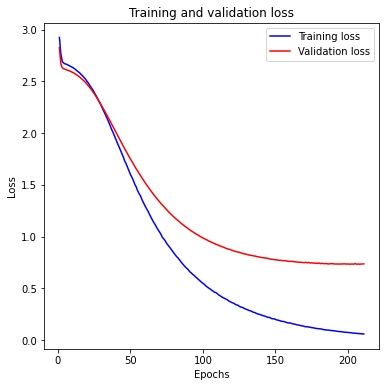

In [51]:
# ploting of loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

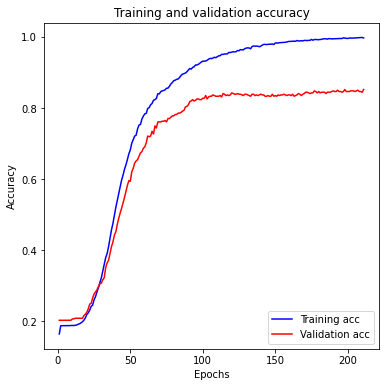

In [52]:
# plotting of accuracy
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Predict

In [53]:
# creating the probability model for testing
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

# predicting test samples
predictions = probability_model.predict(raw_test_batch.map(vectorize_text))

11/11 [==============================] - 0s 2ms/step


In [54]:
# showing the first test sample result label
np.argmax(predictions[0])

17

In [55]:
# showing the true label of the first test sample
test_df.iloc[0]

text         fluke tone on tone premium hooded sweat shirt ...
label                                           Sporting Goods
label_int                                                   17
Name: 4839, dtype: object

We can increase the accuracy with Hypertuning.


### Hypertuning the Simple Keras Model

Install keras-tuner

In [ ]:
!pip install keras-tuner --upgrade

In [56]:
tensor_dataset = {'train_ds': train_ds, 'val_ds': val_ds, 'test_ds': test_ds}

#### Building the Hypertuner Model

In [62]:
import keras_tuner

# Fixed hyper parameters
num_of_labels = 20
vocab_size = len(vectorize_layer.get_vocabulary())

class MyHyperModel(keras_tuner.HyperModel):
    # build method for building the tunable model

    def build(self, hp):
      # model hyperparameters
      dropout_rate1 = hp.Float('dropout_rate1', min_value=0.1, max_value=1, step=0.05)
      dropout_rate2 = hp.Float('dropout_rate2', min_value=0.1, max_value=1, step=0.05)
      embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=256, step=16)
      learn_rate = hp.Choice('learn_rate', [0.01, 0.1, 0.2, 0.3, 0.4], default=0.01)
      
      model = tf.keras.Sequential([
        layers.Embedding(input_dim=vocab_size,                        # input_dim: the size of the vocabulary
                   output_dim=embedding_dim,                          # output_dim: the size of the dense vector
                   input_length=sequence_length),                     # input_length: the length of the sequence
        layers.Dropout(dropout_rate1),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(dropout_rate2),
        layers.Dense(num_of_labels)])

      model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
      return model

    # fit method for fitting the model
    def fit(self, hp, model, dataset, validation_data=None, **kwargs):
      return model.fit(
          dataset['train_ds'],
          validation_data=dataset['val_ds'],
          **kwargs,
      )

#### Starting Random Search

In [64]:
tuner = keras_tuner.RandomSearch(
    MyHyperModel(),
    objective="val_accuracy",
    max_trials=50,
    overwrite=True,
    directory="projects",
    project_name="tune_basic_keras_hypermodel",
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
]

# running the search
tuner.search(tensor_dataset, epochs=300, callbacks=callbacks)

Trial 50 Complete [00h 02m 22s]
val_accuracy: 0.8500948548316956

Best val_accuracy So Far: 0.8595825433731079
Total elapsed time: 01h 49m 55s


#### Random Search Results

In [65]:
# getting a summary of the best results of our tuning.
tuner.results_summary()

Results summary
Results in projects/tune_basic_keras_hypermodel
Showing 10 best trials
Trial summary
Hyperparameters:
dropout_rate1: 0.45000000000000007
dropout_rate2: 0.30000000000000004
embedding_dim: 240
learn_rate: 0.1
Score: 0.8595825433731079
Trial summary
Hyperparameters:
dropout_rate1: 0.2
dropout_rate2: 0.1
embedding_dim: 240
learn_rate: 0.2
Score: 0.8595825433731079
Trial summary
Hyperparameters:
dropout_rate1: 0.15000000000000002
dropout_rate2: 0.55
embedding_dim: 144
learn_rate: 0.2
Score: 0.8576850295066833
Trial summary
Hyperparameters:
dropout_rate1: 0.1
dropout_rate2: 0.7000000000000001
embedding_dim: 160
learn_rate: 0.01
Score: 0.8576850295066833
Trial summary
Hyperparameters:
dropout_rate1: 0.2
dropout_rate2: 0.1
embedding_dim: 160
learn_rate: 0.4
Score: 0.855787456035614
Trial summary
Hyperparameters:
dropout_rate1: 0.25
dropout_rate2: 0.2
embedding_dim: 208
learn_rate: 0.3
Score: 0.855787456035614
Trial summary
Hyperparameters:
dropout_rate1: 0.15000000000000002
dro

In [66]:
# top 5 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Printing the best hp.
best_hps[0].values

{'dropout_rate1': 0.45000000000000007,
 'dropout_rate2': 0.30000000000000004,
 'embedding_dim': 240,
 'learn_rate': 0.1}

#### Building and Training the Best Model

In [78]:
# Building the model with the best hyperparameters.
model_best = tuner.hypermodel.build(best_hps[0])

epochs = 300

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

# Concatenating validation data and training data
train_ds_concatenated = tensor_dataset['train_ds'].concatenate(tensor_dataset['val_ds'])

history = model_best.fit(tensor_dataset['train_ds'],
                        validation_data=tensor_dataset['val_ds'], 
                        epochs=epochs,
                        callbacks=[callback])

Epoch 1/300
85/85 [==============================] - 9s 99ms/step - loss: 2.8027 - accuracy: 0.1837 - val_loss: 2.6368 - val_accuracy: 0.2030
Epoch 2/300
85/85 [==============================] - 0s 6ms/step - loss: 2.6796 - accuracy: 0.1878 - val_loss: 2.6176 - val_accuracy: 0.2030
Epoch 3/300
85/85 [==============================] - 0s 5ms/step - loss: 2.6623 - accuracy: 0.1880 - val_loss: 2.6067 - val_accuracy: 0.2030
Epoch 4/300
85/85 [==============================] - 0s 5ms/step - loss: 2.6489 - accuracy: 0.1882 - val_loss: 2.5931 - val_accuracy: 0.2030
Epoch 5/300
85/85 [==============================] - 0s 5ms/step - loss: 2.6304 - accuracy: 0.1885 - val_loss: 2.5755 - val_accuracy: 0.2068
Epoch 6/300
85/85 [==============================] - 0s 5ms/step - loss: 2.6055 - accuracy: 0.1889 - val_loss: 2.5525 - val_accuracy: 0.2087
Epoch 7/300
85/85 [==============================] - 0s 5ms/step - loss: 2.5746 - accuracy: 0.1963 - val_loss: 2.5241 - val_accuracy: 0.2144
Epoch 8/300


#### Evaluating and Plotting the Trained Model

In [79]:
# Creating a method for evalutaion and testing.
def evaluate_and_plot(model, test_ds, history):
  loss, accuracy = model.evaluate(test_ds)
  print("Model Loss: ", loss)
  print("Model Accuracy: ", accuracy)

  # extracting the history of training and its keys
  history_dict = history.history
  history_dict.keys()

  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # ploting of loss
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # plotting of accuracy
  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

11/11 [==============================] - 0s 3ms/step - loss: 0.7130 - accuracy: 0.8387
Model Loss:  0.7130247950553894
Model Accuracy:  0.8387096524238586


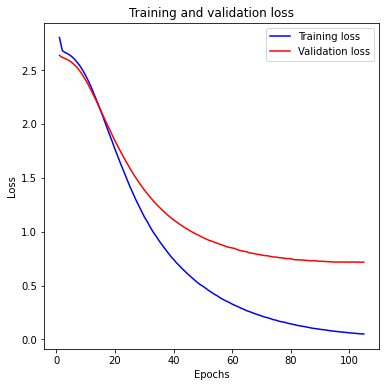

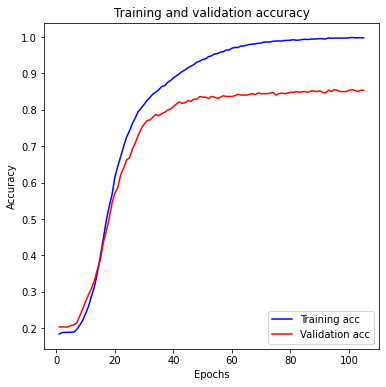

In [80]:
evaluate_and_plot(model_best, tensor_dataset['test_ds'], history)

As we can see the validation loss is much better.

## XGBoost Model
Our first model is the XGBoost Model.

### XGBoost Data Preprocessing

In [30]:
train_text = []
train_labels = []
for text_batch, labels_batch in train_ds:
  for text in text_batch:
    train_text.append(text.numpy().tolist())
  for labels in labels_batch:
    train_labels.append(labels.numpy().tolist())

val_text = []
val_labels = []
for text_batch, labels_batch in val_ds:
  for text in text_batch:
    val_text.append(text.numpy().tolist())
  for labels in labels_batch:
    val_labels.append(labels.numpy().tolist())

test_text = []
test_labels = []
for text_batch, labels_batch in test_ds:
  for text in text_batch:
    test_text.append(text.numpy().tolist())
  for labels in labels_batch:
    test_labels.append(labels.numpy().tolist())

The accepted data format for XGBClassifier is:   


```
ndarray([[ 5,  5,  3, ...,  4,  0,  0],  
       [ 2,  2,  0, ...,  8,  1, 17],  
       [ 1,  2,  3, ..., 12,  0, 10],   
       ...,
       [ 0,  6,  5, ...,  8,  4,  8],
       [ 3,  4,  8, ...,  6,  1, 15],   
       [ 0,  2,  0, ...,  2,  1, 13]])
```



In [32]:
train_text = np.array(train_text).T
train_labels = np.array(train_labels).T
val_text = np.array(val_text).T
val_labels = np.array(val_labels).T
test_text = np.array(test_text).T
test_labels = np.array(test_labels).T
print(train_text.shape, train_labels.shape)
print(val_text.shape, val_labels.shape)
print(test_text.shape, test_labels.shape)

(4213, 310) (4213,)
(527, 310) (527,)
(527, 310) (527,)


In [38]:
training_data = {'train_text': train_text, 'train_labels': train_labels, 
                 'val_text': val_text, 'val_labels': val_labels,
                 'test_text': test_text, 'test_labels': test_labels}

### XGBoost Training

### Creating the XGBoost Model

Plot_compare methods for plotting the model and fitXgb method for training the XGBoost model.

In [41]:
from sklearn.metrics import accuracy_score, f1_score
import xgboost

# Plotting and comparing the train and test loss
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()

''' 
  Fitting the XGBClassifier and training an XGBoost model with the fitted parameters.     
  We want to plot the validation error and training errors on each epoch and thats why we also train an XGBoost model which is 
  the same as XGBClassifier, but with the ability to store training history.
'''
def fitXgb(xgb_classifier, training_data=training_data,epochs=300):
    print('Fitting model...')
    xgb_classifier.fit(training_data['train_text'], training_data['train_labels']) # Fitting the XGBClassifier
    print('Fitting done!')
    train = xgboost.DMatrix(training_data['train_text'], label=training_data['train_labels']) # Training data matrix for XGBoost model
    val = xgboost.DMatrix(training_data['val_text'], label=training_data['val_labels']) # Validation data matrix for XGBoost model
    params = xgb_classifier.get_xgb_params() # Getting the XGBClassifier parameters
    metrics = ['mlogloss','merror']
    params['eval_metric'] = metrics
    store = {}
    evallist = [(val, 'val'),(train,'train')]
    xgb_model = xgboost.train(params, train, epochs, evallist, evals_result=store, verbose_eval=100) #Training the XGBoost model
    print('-- Model Report --')
    predictions = xgb_classifier.predict(training_data['test_text'])
    print('XGBoost Accuracy: '+str(accuracy_score(predictions, training_data['test_labels'])))
    print('XGBoost F1-Score (Micro): '+str(f1_score(predictions, training_data['test_labels'], average='micro')))
    plot_compare(metrics,store,epochs)

Fitting and training the XGBoost model.

Fitting model...
Fitting done!
[0]	val-mlogloss:2.91972	val-merror:0.800759	train-mlogloss:2.8729	train-merror:0.680987
[100]	val-mlogloss:2.39196	val-merror:0.690702	train-mlogloss:0.793092	train-merror:0.074769
[200]	val-mlogloss:2.47462	val-merror:0.681214	train-mlogloss:0.351384	train-merror:0.005934
[299]	val-mlogloss:2.58097	val-merror:0.677419	train-mlogloss:0.176824	train-merror:0.000712
-- Model Report --
XGBoost Accuracy: 0.3187855787476281
XGBoost F1-Score (Micro): 0.3187855787476281


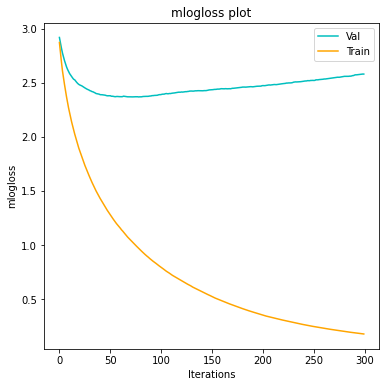

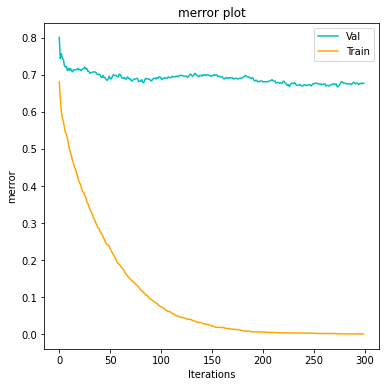

In [42]:
#initial model
xgb1 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=20,
                    seed=27)

fitXgb(xgb1, training_data)

The model is overfitting! Maybe we should hypertune our model.

### Hypertuning our XGBoost Model with Random Search Tuning

In [43]:
# A parameter grid for XGBoost
params = {
          'n_estimators': [100, 200],
          'min_child_weight': [1, 5, 10],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [3, 4, 5, 6],
         }

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(estimator=xgb1, param_distributions=params, n_iter=param_comb, scoring='accuracy', verbose=10, random_state= 1001, cv=skf)
search_result = random_search.fit(train_text, train_labels)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3; 1/5] START colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, n_estimators=100, subsample=0.8
[CV 1/3; 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, n_estimators=100, subsample=0.8;, score=0.270 total time=  29.0s
[CV 2/3; 1/5] START colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, n_estimators=100, subsample=0.8
[CV 2/3; 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, n_estimators=100, subsample=0.8;, score=0.266 total time=  30.9s
[CV 3/3; 1/5] START colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, n_estimators=100, subsample=0.8
[CV 3/3; 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, n_estimators=100, subsample=0.8;, score=0.280 total time=  36.9s
[CV 1/3; 2/5] START colsample_bytree=1.0, gamma=1.5, max_depth=5, min_child_weight=1, n_estimators=200, subsample=1.0
[CV 1/3; 2/5] E

### Testing Optimum XGBClassifier Accuracy

In [44]:
# getting the best XGBoost Model
y_pred = search_result.predict(test_text)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
print("XGBoost Accuracy: %.2f%%" % (accuracy * 100.0))

XGBoost Accuracy: 31.88%


We are still overfitting! Our dataset is too small! XGBoost is not optimal for our problem!

## Building Cusomized Keras Model

In [82]:
def create_customized_model(num_filters, kernel_size, vocab_size, sequence_length, dropout_rate, embedding_dim,hidden_dims,num_of_classes):
  # Created Embedding (Input) Layer (max_words) --> Convolutional Layer
  model = tf.keras.Sequential([
  layers.Embedding(input_dim=vocab_size,                              # input_dim: the size of the vocabulary
                   output_dim=embedding_dim,                          # output_dim: the size of the dense vector
                   input_length=sequence_length),                     # input_length: the length of the sequence

  # Create the convolutional layer
  layers.Conv1D(num_filters, kernel_size, padding='valid', activation='relu', strides=1),
  # Create the pooling layer
  layers.GlobalMaxPool1D(),
  layers.Dropout(dropout_rate),
  # layers.Dense(hidden_dims),
  # layers.Activation('relu'),
  # layers.Dropout(0.75),

  # Create the output layer
  layers.Dense(num_of_classes),
  layers.Activation('softmax'),
  ])
  model.summary()
  return model

In [99]:
# model configuration

# hyper parameters
epochs = 200
vocab_size = len(vectorize_layer.get_vocabulary())


# num_filters, kernel_size, vocab_size, sequence_length, embedding_dim,hidden_dims,num_of_classes
model = create_customized_model(250, 5, vocab_size, sequence_length, 0.95, 50, 150, len(labels_names))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 310, 50)           818550    
                                                                 
 conv1d (Conv1D)             (None, 306, 250)          62750     
                                                                 
 global_max_pooling1d (Globa  (None, 250)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_12 (Dropout)        (None, 250)               0         
                                                                 
 dense_6 (Dense)             (None, 20)                5020      
                                                                 
 activation (Activation)     (None, 20)                0         
                                                      

### Initialzing Model

In [100]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.007, momentum=0.8, nesterov=True)

# model compilation
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

### Train

In [101]:
# training the model
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
]

history = model.fit(train_ds,
                    verbose= True,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/200
85/85 [==============================] - 12s 75ms/step - loss: 2.9169 - accuracy: 0.1249 - val_loss: 2.8094 - val_accuracy: 0.2030
Epoch 2/200
85/85 [==============================] - 1s 8ms/step - loss: 2.8312 - accuracy: 0.1773 - val_loss: 2.7404 - val_accuracy: 0.2030
Epoch 3/200
85/85 [==============================] - 1s 7ms/step - loss: 2.7965 - accuracy: 0.1804 - val_loss: 2.7106 - val_accuracy: 0.2030
Epoch 4/200
85/85 [==============================] - 1s 7ms/step - loss: 2.7698 - accuracy: 0.1854 - val_loss: 2.6917 - val_accuracy: 0.2030
Epoch 5/200
85/85 [==============================] - 1s 7ms/step - loss: 2.7391 - accuracy: 0.1873 - val_loss: 2.6760 - val_accuracy: 0.2030
Epoch 6/200
85/85 [==============================] - 1s 8ms/step - loss: 2.7352 - accuracy: 0.1875 - val_loss: 2.6664 - val_accuracy: 0.2030
Epoch 7/200
85/85 [==============================] - 1s 10ms/step - loss: 2.7277 - accuracy: 0.1885 - val_loss: 2.6621 - val_accuracy: 0.2030
Epoch 8/20

### Test

In [102]:
# printing loss and accuracy of the model on the test set
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

11/11 [==============================] - 0s 3ms/step - loss: 1.2397 - accuracy: 0.6983
Loss:  1.23967444896698
Accuracy:  0.6982921957969666


In [103]:
# extracting the history of training and its keys
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [104]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

### Plotting Results

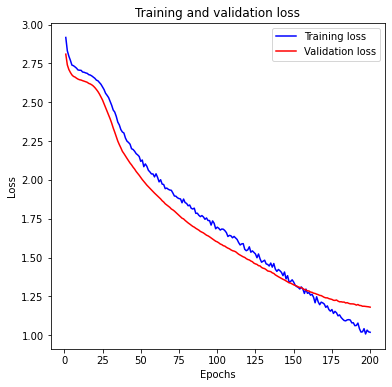

In [105]:
# ploting of loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

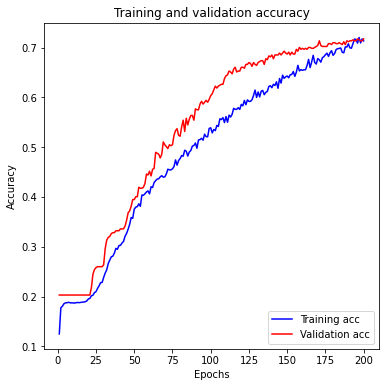

In [106]:
# plotting of accuracy
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Predict

In [107]:
# creating the probability model for testing
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

# predicting test samples
predictions = probability_model.predict(raw_test_batch.map(vectorize_text))

11/11 [==============================] - 0s 2ms/step


In [108]:
# showing the first test sample result label
np.argmax(predictions[0])

1

In [109]:
# showing the true label of the first test sample
test_df.iloc[0]

text         fluke tone on tone premium hooded sweat shirt ...
label                                           Sporting Goods
label_int                                                   17
Name: 4839, dtype: object

As we can see the accuracy is around 70% which is quite low! We should hypertune our model.

### Hypertuning My Customized Model

#### Building the Hypertuner Model

In [112]:
# Fixed hyper parameters
num_of_labels = 20
vocab_size = len(vectorize_layer.get_vocabulary())

class CustomHyperModel(keras_tuner.HyperModel):
    # build method for building the tunable model

    def build(self, hp):
      # model hyperparameters
      num_filters = hp.Choice('num_filters', [32, 64, 128, 256], default=256)
      kernel_size = hp.Choice('kernel_size', [3, 4, 5, 10], default=5)
      dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=1, step=0.05)
      embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=256, step=16)
      learn_rate = hp.Choice('learn_rate', [0.01, 0.1, 0.2, 0.3, 0.4], default=0.01)
      
      model = create_customized_model(num_filters, kernel_size, vocab_size, sequence_length, dropout_rate, embedding_dim, 150, len(labels_names)) 

      model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
      return model

    # fit method for fitting the model
    def fit(self, hp, model, dataset, validation_data=None, **kwargs):
      return model.fit(
          dataset['train_ds'],
          validation_data=dataset['val_ds'],
          **kwargs,
      )

#### Starting Random Search

In [113]:
tuner = keras_tuner.RandomSearch(
    CustomHyperModel(),
    objective="val_accuracy",
    max_trials=50,
    overwrite=True,
    directory="projects",
    project_name="tune_custom_keras_hypermodel",
)

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1),]

tuner.search(tensor_dataset, epochs=300, callbacks=callbacks)

Trial 50 Complete [00h 00m 22s]
val_accuracy: 0.8292220234870911

Best val_accuracy So Far: 0.8500948548316956
Total elapsed time: 00h 25m 46s


#### Random Search Results

In [114]:
tuner.results_summary()

Results summary
Results in projects/tune_custom_keras_hypermodel
Showing 10 best trials
Trial summary
Hyperparameters:
num_filters: 128
kernel_size: 3
dropout_rate: 0.4
embedding_dim: 128
learn_rate: 0.1
Score: 0.8500948548316956
Trial summary
Hyperparameters:
num_filters: 256
kernel_size: 3
dropout_rate: 0.45000000000000007
embedding_dim: 240
learn_rate: 0.01
Score: 0.8500948548316956
Trial summary
Hyperparameters:
num_filters: 128
kernel_size: 3
dropout_rate: 0.1
embedding_dim: 80
learn_rate: 0.2
Score: 0.848197340965271
Trial summary
Hyperparameters:
num_filters: 64
kernel_size: 4
dropout_rate: 0.2
embedding_dim: 128
learn_rate: 0.4
Score: 0.8462998270988464
Trial summary
Hyperparameters:
num_filters: 256
kernel_size: 3
dropout_rate: 0.35
embedding_dim: 112
learn_rate: 0.1
Score: 0.8462998270988464
Trial summary
Hyperparameters:
num_filters: 128
kernel_size: 5
dropout_rate: 0.7000000000000001
embedding_dim: 256
learn_rate: 0.2
Score: 0.8444022536277771
Trial summary
Hyperparameters:

In [115]:
# top 5 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Printing the best hp.
best_hps[0].values

{'num_filters': 128,
 'kernel_size': 3,
 'dropout_rate': 0.4,
 'embedding_dim': 128,
 'learn_rate': 0.1}

#### Building and Training the Best Model

In [121]:
model_best = tuner.hypermodel.build(best_hps[0])

epochs = 300

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=5,
                                            verbose=1)

# Concatenating validation data and training data
train_ds_concatenated = tensor_dataset['train_ds'].concatenate(tensor_dataset['val_ds'])

history = model_best.fit(train_ds_concatenated,
                        validation_data=tensor_dataset['test_ds'], 
                        epochs=epochs,
                        callbacks=[callback])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 310, 128)          2095488   
                                                                 
 conv1d_5 (Conv1D)           (None, 308, 128)          49280     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 20)                2580      
                                                                 
 activation_5 (Activation)   (None, 20)                0         
                                                      

#### Evaluating and Plotting the Trained Model

11/11 [==============================] - 0s 4ms/step - loss: 0.7230 - accuracy: 0.8254
Model Loss:  0.7230067849159241
Model Accuracy:  0.8254269361495972


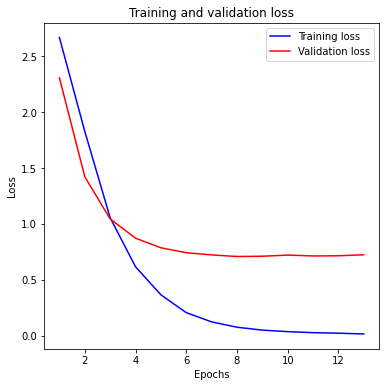

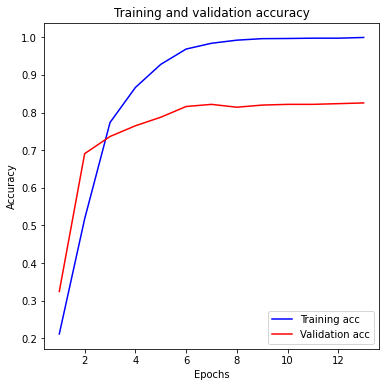

In [122]:
evaluate_and_plot(model_best, tensor_dataset['test_ds'], history)

As we can see we managed to increase our customized model's accuracy significantly with hyperparameter tuning.